# Experiments with Arnoldi iterations

The [Arnoldi algorithm](http://en.wikipedia.org/wiki/Arnoldi_iteration), described in e.g. chapter 33 of *Numerical Linear Algebra* by Trefethen and Bau, iteratively constructs an $m\times m$ orthonormal basis $Q_n$ for the Krylov space $\mathcal{K}_n$ spanned by $\{b,Ab,A^2 b,\ldots,A^{n-1}b\}$ for an $m\times m$ matrix $A$ and some starting vector $b$, along with the upper-Hessenberg Rayleigh–Ritz (or Galerkin) matrix $H_n = Q_n^* A Q_n$.   Approximate eigenvalues of $A$ are then found from the eigenvalues of $H_n$ (the *Ritz values*).

The basic iteration is essentially just a modified Gram–Schmidt orthonormalization applied successively to $Aq_n$, where $q_n$ was the previously constructed basis vector.   (This MGS process is also at the heart of the [GMRES](http://en.wikipedia.org/wiki/Generalized_minimal_residual_method) algorithm for $Ax=b$.)

In this notebook, we implement a simplistic version of the unrestarted Arnoldi algorithm in the Julia language, and perform some experiments with its convergence and other properties.

In [4]:
using LinearAlgebra

In [1]:
# Arnoldi algorithm to form an orthonormal basis Q for the Krylov space {b,Ab,A²b,...},
# with no restarting.  Returns the matrices H and Q after niters iterations.
# (This is a straightforward transcription of algorithm 33.1 in Trefethen & Bau, with
#  no concern for efficiency.)
function arnoldi(A, b, niters=50)
    m = length(b)
    Q = zeros(m, niters)
    Q[:,1] = b / norm(b)
    H = zeros(niters, niters-1)
    for n = 1:niters-1
        v = A*Q[:,n]
        for j = 1:n
            q = Q[:,j]
            H[j,n] = dot(q,v)
            v -= q * H[j,n]
        end
        H[n+1,n] = norm(v)
        Q[:,n+1] = v / H[n+1,n]
    end
    return H, Q
end

arnoldi (generic function with 2 methods)

We construct a random non-Hermitian matrix $A$ with real eigenvalues λ that are logarithmically spaced from $10^{-2}$ to $10^{3}$ (so that they are clustered around the small values), and a random starting vector $b$ for the Arnoldi iteration:

In [5]:
X = randn(1000,1000)
λ = 2 .^ range(-2, 3, length= 1000)
A = X \ diagm(λ) * X
b = randn(1000)
λ

1000-element Array{Float64,1}:
 0.25               
 0.25086880744121426
 0.2517406341879081 
 0.2526154907328619 
 0.2534933876053207 
 0.2543743353711211 
 0.25525834463281855
 0.2561454260298146 
 0.2570355902384854 
 0.25792884797230975
 0.25882520998199837
 0.2597246870556232 
 0.260627290018747  
 ⋮                  
 7.700461679915994  
 7.727222553549179  
 7.754076427366947  
 7.781023624566308  
 7.808064469467456  
 7.835199287517671  
 7.862428405295239  
 7.889752150513377  
 7.917170852024186  
 7.944684839822598  
 7.972294445050357  
 8.0                

The output of the arnoldi iteration is the basis $Q$ and an upper-Hessenberg matrix $H$ giving the entries of $Q^* A Q$.  (Technically, $H$ is non-square, since it relates $Q_n$ to $Q_{n+1}$ via $AQ_n = Q_{n+1} H_n$.)

In [6]:
H, Q = arnoldi(A, b, 50)
H

50×49 Array{Float64,2}:
  3.67764  0.172949  0.0562279  -0.059142  …    0.0237485   -1.1632   
 52.4819   2.01284   0.307521    4.51821       18.7189      25.1567   
  0.0      3.92741   3.22208    -7.81184      -20.9808     -71.2674   
  0.0      0.0       0.764561    6.69904       10.2169      17.3299   
  0.0      0.0       0.0         1.38298       -3.23088      3.90085  
  0.0      0.0       0.0         0.0       …    2.78258      8.28204  
  0.0      0.0       0.0         0.0           10.1426      12.5631   
  0.0      0.0       0.0         0.0           -3.11614     -7.72886  
  0.0      0.0       0.0         0.0           -1.1656       5.05254  
  0.0      0.0       0.0         0.0           -2.46019     -0.323798 
  0.0      0.0       0.0         0.0       …   -0.35264      4.23895  
  0.0      0.0       0.0         0.0            2.66577      1.01061  
  0.0      0.0       0.0         0.0           -1.55486      1.00127  
  ⋮                                        ⋱         

## Arnoldi convergence rates

Now, we will look at the convergence rate of Arnoldi, by comparing the Ritz values $\nu$ to the exact eigenvalues $\lambda$.   In particular, we will look at the Ritz values with the *maximum real parts* and compare them to the corresponding eigenvalues:

In [16]:
# Given the Arnoldi matrix H and the exact eigenvalues λ, return the absolute errors
# in the nev eigenvalues with the largest real parts as an array of errors in each iteration.
function arnoldi_convergence(H, λ, nev=6)
    λ₀ = sort(λ, by=real)[length(λ)-nev+1:end]
    errs = zeros(size(H,2) - nev+1, nev)
    for n = nev:size(H,2)
        ν = sort(eigvals(H[1:n,1:n]), by=real)
        errs[n-nev+1, :] = abs.(ν[length(ν)-nev+1:end] - λ₀)
    end
    return errs
end

arnoldi_convergence (generic function with 2 methods)

Since, for this particular $A$, the eigenvalue with the largest real part is also the eigenvalue with maximum $|\lambda| = 1000$, it is instructive to compare the Arnoldi convergence to that of the simple [power method](http://en.wikipedia.org/wiki/Power_iteration) where we repeatedly multiply by $A$ (and normalize, to avoid floating-point overflow).   This should be worse than the Arnoldi iteration, since it basically corresponds to keeping only the last vector $A^{n-1} b$ of the Krylov subspace $\mathcal{K}_n$.

In [17]:
# Return the absolute errors and the (approximate) eigenvalues for niters iterations
# of the power method applied to A with a starting vector b, compared to the exact eigenvalues λ.
function power_convergence(A, b, λ, niters=100)
    λ₀ = sort(λ, by=abs)[end]
    x = b / norm(b)
    eigs = [dot(x,A*x)]
    errs = [abs(eigs[end] - λ₀) / abs(λ₀)]
    for n in 1:niters-1
        x = A*x
        x = x / norm(x)
        push!(eigs, dot(x,A*x))
        push!(errs, abs(eigs[end] - λ₀))
    end
    return errs, eigs
end

power_convergence (generic function with 2 methods)

In [18]:
power_convergence(A, b, λ, 20)

([0.5402950987476116, 2.307295530462625, 0.9291828022415638, 1.2859394431211646, 1.4726330752054304, 1.3646853686798082, 0.9739496932488603, 0.4489192322610478, 0.037843854711626435, 0.1585745812299013, 0.19987425071972353, 0.16722073182738129, 0.10931939551169556, 0.04826322823562634, 0.007544468378307911, 0.055690985997213005, 0.09614945547866949, 0.1297301056897613, 0.1574461700997185, 0.18027006792414646], [3.677639210019107, 5.692704469537375, 7.070817197758436, 6.714060556878835, 6.52736692479457, 6.635314631320192, 7.02605030675114, 7.551080767738952, 7.962156145288374, 8.158574581229901, 8.199874250719724, 8.167220731827381, 8.109319395511696, 8.048263228235626, 7.992455531621692, 7.944309014002787, 7.9038505445213305, 7.870269894310239, 7.8425538299002815, 7.8197299320758535])

Let's plot the convergence rates (as absolute errors $|\nu - \lambda|$) as a function of the number of iterations, for both Arnoldi and the power method:

In [10]:
using PyPlot

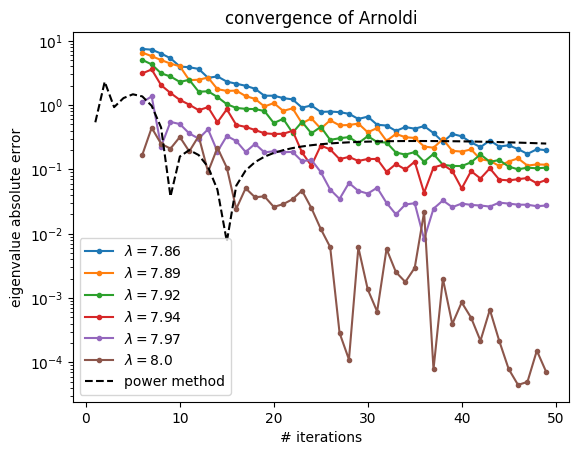

In [21]:
nev = 6
semilogy(nev:size(H,2), arnoldi_convergence(H, λ, nev), ".-")
semilogy(1:size(H,2), power_convergence(A, b, λ, size(H,2))[1], "k--")
legend(push!(["\$\\lambda = $(round(λ[end-nev+n],digits=2))\$" for n in 1:nev], "power method"), loc="lower left")
ylabel("eigenvalue absolute error")
xlabel("# iterations")
title("convergence of Arnoldi");

The biggest $\lambda$ is converging the fastest, and all of the eigenvalues are converging must faster than the power iteration, which is converging so slowly that we need to plot it for more iterations to be sure that it is converging at all (as of course it must for distinct $|\lambda|$).  For reference, we also plot the ratio $|\lambda_2/\lambda_1|^n$ where $\lambda_1$ is the biggest eigenvalue and $\lambda_2$ is the second-biggest — this is the theoretical convergence rate of the power method for non-Hermitian $A$.  (For Hermitian $A$, the Rayleigh–Ritz estimate squares this error.) 

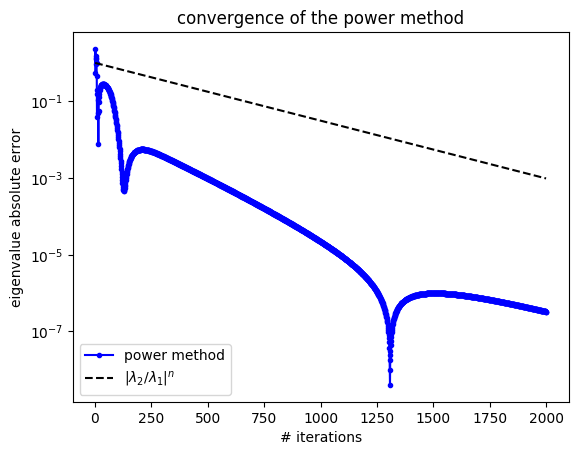

In [24]:
niters = 2000
semilogy(1:niters, power_convergence(A, b, λ, niters)[1], "b.-")
λabs = sort(abs.(λ))
semilogy(1:niters, (λabs[end-1]/λabs[end]).^(1:niters), "k--")
title("convergence of the power method")
ylabel("eigenvalue absolute error")
xlabel("# iterations")
legend(["power method", L"|\lambda_2/\lambda_1|^n"], loc="lower left");

### Arnoldi for shifted eigenvalues

One of the interesting properties of the Arnoldi algorithm that one can prove from a polynomial perspective (see Trefethen, ch. 34) is that the convergence rate of $A + \mu I$ is independent of the shift $\mu$.  All that matters is where the ends/extrema of the spectrum are, not where the spectrum is centered.

This is *not* true of the power method, because $|\lambda_2/\lambda_1|^n \ne |(\lambda_2+\mu)/(\lambda_1+\mu)|^n$. 

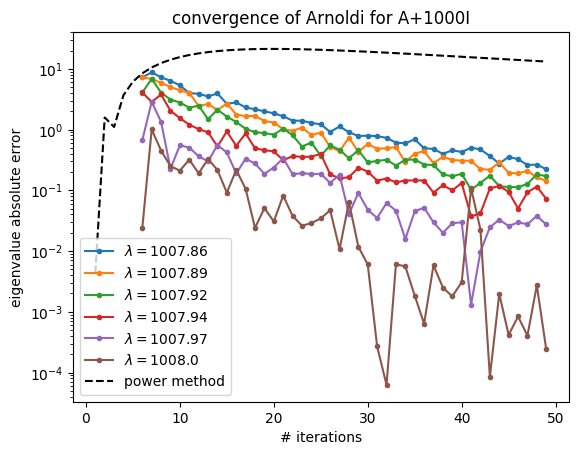

In [28]:
Hₛ, = arnoldi(A + 1000*I, b, 50)
semilogy(nev:size(Hₛ,2), arnoldi_convergence(Hₛ, λ .+ 1000., nev), ".-")
semilogy(1:size(Hₛ,2), power_convergence(A + 1000*I, b, λ .+ 1000., size(Hₛ,2))[1], "k--")
legend(push!(["\$\\lambda = $(round(1000+λ[end-nev+n],digits=2))\$" for n in 1:nev], "power method"), loc="lower left")
ylabel("eigenvalue absolute error")
xlabel("# iterations")
title("convergence of Arnoldi for A+1000I");

If you look carefully, you see that the convergence curves of Arnoldi are identical to the previous convergence plot, at least for the first few iterations.  After many iterations, roundoff errors cause the results for $A$ and $A+1000I$ to differ slightly, but nevertheless the convergence rates remain very similar.  The power method, on the other hand, is converging more slowly than before.

This perhaps even more dramatic if we consider $A - 999.999I$, which shifts the largest-magnitude eigenvalue $\lambda=1000$ into the smallest-magnitude eigenvalue $\lambda=0.001$.  Arnoldi doesn't care, but the power method would converge to a completely different eigenvalue (so I don't bother to show it on the plot):

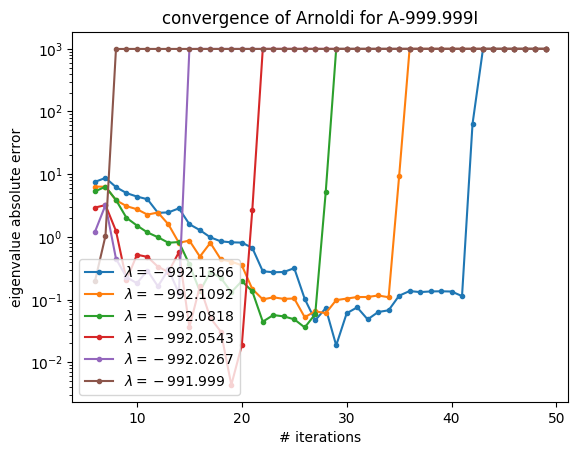

In [36]:
Hₛ, = arnoldi(A - 999.999 *I, b, 50)
semilogy(nev:size(Hₛ,2), arnoldi_convergence(Hₛ, λ .- 999.999, nev), ".-")
legend(["\$\\lambda = $(round(λ[end-nev+n]-999.999,digits=4))\$" for n in 1:nev], loc="lower left")
ylabel("eigenvalue absolute error")
xlabel("# iterations")
title("convergence of Arnoldi for A-999.999I");

While it is true that the *absolute error* $|\lambda - \nu|$ of Arnoldi is independent of the shift $\mu$ in the eigenvalues, the *relative error* $|\lambda - \nu|/|\lambda|$ is certainly shift-dependent if we put $\lambda + \mu$ in the denominator.  In the case above, where we shift $\lambda + \mu$ to be nearly zero, the relative error (as a fraction of $|\lambda + \mu|$) is much larger for the same number of iterations.  On the other hand, if you know a $\mu$ such that $\lambda + \mu$ is very small, you can apply Arnoldi to the shifted inverse $(A + \mu I)^{-1}$ (which may require an iterative or sparse solver if $A$ is large and sparse) and greatly accelerate convergence.

### Arnoldi for the smallest eigenvalues

We can similarly use Arnoldi to find the eigenvalues with the *minimum* real parts.   Rather than modifying the code above, I simply replace $A$ with $-A$ so that the eigenvalue order reverses.   This yields slower convergence than before because the minimum eigenvalues of this $A$ were constructed to be much more closely spaced.

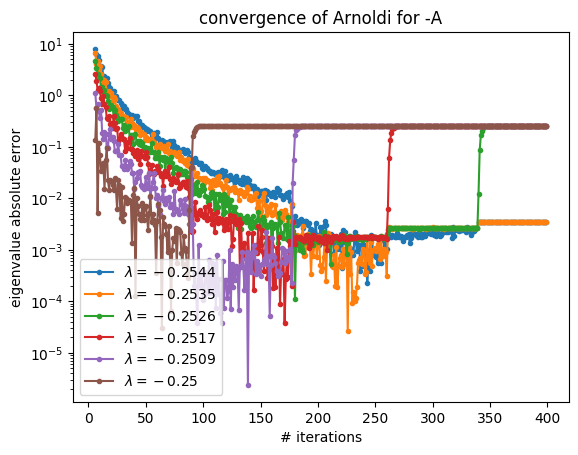

PyObject Text(0.5, 1, 'convergence of Arnoldi for -A')

In [37]:
Hₘ, = arnoldi(-A, b, 400)
semilogy(nev:size(Hₘ,2), arnoldi_convergence(Hₘ, -λ, nev), ".-")
legend(["\$\\lambda = $(round(-λ[nev-n+1],digits=4))\$" for n in 1:nev], loc="lower left")
ylabel("eigenvalue absolute error")
xlabel("# iterations")
title("convergence of Arnoldi for -A")

## Arnoldi for Hermitian matrices: Lanczos iterations

When it is applied to a Hermitian matrix $A_h = A_h^*$, the Arnoldi algorithm simplifies dramatically because the Galerkin matrix $H_n$ becomes [tridiagonal](http://en.wikipedia.org/wiki/Tridiagonal_matrix).   In this case, the Arnoldi algorithm can be simplified to the [Lanczos algorithm](http://en.wikipedia.org/wiki/Lanczos_algorithm), described in e.g. Trefethen ch. 36.

In [38]:
Xₕ, = qr(randn(1000,1000)) # a random unitary matrix via QR on a random matrix
Aₕ = Xₕ' * diagm(λ) * Xₕ
Hₕ, Qₕ = arnoldi(Aₕ, b, 50)
Hₕ

50×49 Array{Float64,2}:
 2.21618  2.01361  3.15069e-15  -4.56601e-15  …  -3.70114e-8    5.0489e-8  
 2.01361  4.46916  2.08545      -4.7436e-15      -3.38663e-8    4.61987e-8 
 0.0      2.08545  4.40712       1.96329         -7.254e-9      9.89552e-9 
 0.0      0.0      1.96329       4.03371         -6.52938e-9    8.90703e-9 
 0.0      0.0      0.0           1.88434          2.96324e-9   -4.04229e-9 
 0.0      0.0      0.0           0.0          …  -4.18645e-9    5.71094e-9 
 0.0      0.0      0.0           0.0             -1.18347e-8    1.61443e-8 
 0.0      0.0      0.0           0.0             -7.25889e-9    9.9022e-9  
 0.0      0.0      0.0           0.0             -4.337e-9      5.9163e-9  
 0.0      0.0      0.0           0.0             -3.26906e-9    4.45948e-9 
 0.0      0.0      0.0           0.0          …  -1.1542e-9     1.5745e-9  
 0.0      0.0      0.0           0.0              5.24006e-11  -7.1482e-11 
 0.0      0.0      0.0           0.0              3.74421e-10  -

The $H$ matrix above is tridiagonal plus slightly nonzero values in the upper triangle due to rounding errors.  This can also be seen by plotting:

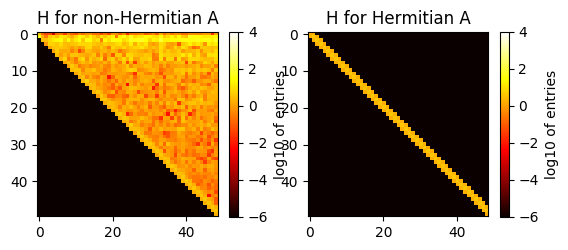

In [44]:
subplot(1,2,1)
title("H for non-Hermitian A")
imshow(log10.(abs.(H) .+ 1e-16), cmap="hot", vmin=-6, vmax=4)
colorbar(shrink=0.5, label="log10 of entries")
subplot(1,2,2)
title("H for Hermitian A")
imshow(log10.(abs.(Hₕ) .+ 1e-16), cmap="hot", vmin=-6, vmax=4)
colorbar(shrink=0.5, label="log10 of entries");

Since most of the entries of $H$ are zero (in exact arithmetic), we can specialize the Arnoldi iterations by omitting computations with these zeros, and the result is the Lanczos algorithm, which returns a real-symmetric tridiagonal matrix.  (In Julia, such matrices can be efficiently stored and worked with by wrapping them in the `SymTridiagonal` type, which only stores the nonzero elements and uses efficient algorithms for eigensolvers etc.)

In [47]:
# Lanczos method: direct transcription of Trefethen algorithm 36.1, with no regard for efficiency
# ... returns the tridiagonal matrix T (from A in the Lanczos/Arnoldi basis, equivalent to H above).
function lanczos(A, b, niters=50)
    α = Float64[]
    β = Float64[0]
    q₀ = zero(b)
    qₙ = b / norm(b)
    for n = 1:niters
        v = A*qₙ
        push!(α, dot(qₙ,v))
        v -= β[end]*q₀ + α[end]*qₙ
        push!(β, norm(v))
        q₀ = qₙ
        qₙ = v / β[end]
    end
    return SymTridiagonal(α, β[2:end-1])
end

lanczos (generic function with 2 methods)

The resulting matrix entries $T$ should be **exactly the same** as our $H$ matrix above, up to roundoff errors:

In [48]:
T = lanczos(Aₕ, b, 50)

50×50 SymTridiagonal{Float64,Array{Float64,1}}:
 2.21618  2.01361   ⋅        ⋅       …   ⋅        ⋅        ⋅        ⋅     
 2.01361  4.46916  2.08545   ⋅           ⋅        ⋅        ⋅        ⋅     
  ⋅       2.08545  4.40712  1.96329      ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅       1.96329  4.03371      ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅       1.88434      ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅       …   ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅           ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅           ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅           ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅           ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅       …   ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅           ⋅        ⋅        ⋅        ⋅     
  ⋅        ⋅        ⋅        ⋅           ⋅        ⋅ 

### Convergence of Lanczos

Since Lanczos is equivalent to Arnoldi with operations on zeros omitted, in exact arithmetic its convergence rate is identical to Arnoldi.  In practice, roundoff errors mean that our $q$ vectors gradually lose orthogonality and cause *ghost eigenvalues* to appear: basically, the maximum-$\lambda$ eigenvalue re-appears over and over again.

In [53]:
# analogous to arnoldi_convergence above
function lanczos_convergence(T, λ, nev=6)
    λ₀ = sort(λ, by=real)[length(λ)-nev+1:end]
    errs = zeros(size(T,2) - nev+1, nev)
    eigs = copy(errs)
    for n = nev:size(T,2)
        Tₙ = SymTridiagonal(T.dv[1:n], T.ev[1:n-1])
        ν = sort(eigvals(Tₙ), by=real)
        eigs[n-nev+1, :] = ν[length(ν)-nev+1:end]
        errs[n-nev+1, :] = abs.(ν[length(ν)-nev+1:end] - λ₀)
    end
    return errs, eigs
end

lanczos_convergence (generic function with 2 methods)

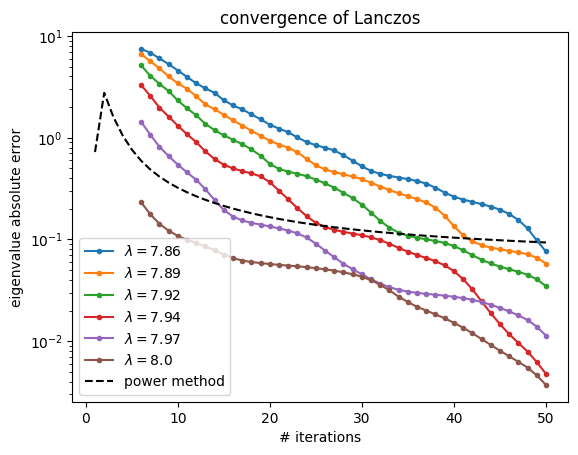

In [55]:
nev = 6
semilogy(nev:size(T,2), lanczos_convergence(T, λ, nev)[1], ".-")
semilogy(1:size(T,2), power_convergence(Aₕ, b, λ, size(T,2))[1], "k--")
legend(push!(["\$\\lambda = $(round(λ[end-nev+n],digits=2))\$" for n in 1:nev], "power method"), loc="lower left")
ylabel("eigenvalue absolute error")
xlabel("# iterations")
title("convergence of Lanczos");

The above graph looks pretty good!   But if we continue for more iterations, a disaster eventually occurs in every eigenvalue except the maximum λ:

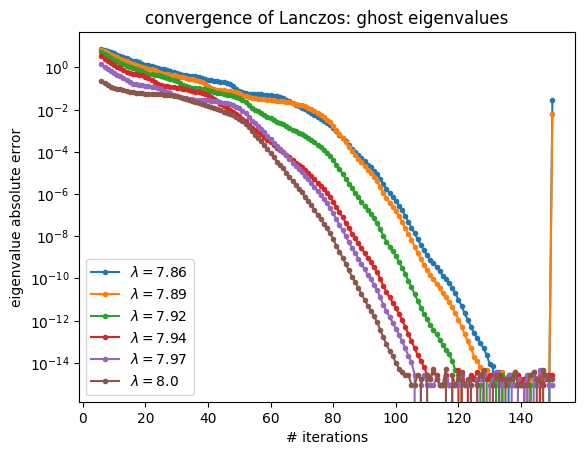

In [58]:
T′ = lanczos(Aₕ, b, 150)
semilogy(nev:size(T′,2), lanczos_convergence(T′, λ, nev)[1], ".-")
legend(["\$\\lambda = $(round(λ[end-nev+n],digits=2))\$" for n in 1:nev], loc="lower left")
ylabel("eigenvalue absolute error")
xlabel("# iterations")
title("convergence of Lanczos: ghost eigenvalues");

To fix this problem, we need to keep our entire $Q$ matrix around and re-orthogonalize occasionally.  Unfortunately, if we keep $Q$ around, both Arnoldi and Lanczos have the same problem: the computational work grows as $\Theta(mn^2)$ and the storage grows as $\Theta(mn)$.  In real applications where $m$ could be $10^7$ or more, you can't run for very many iterations $n$ before it becomes too expensive (in both time and memory), at which point you have to *restart* the algorithm.   In particular, one usually employs so-called [implicit restarting methods](http://web.eecs.utk.edu/~dongarra/etemplates/node118.html) that preserve key properties of the Lanczos process under restarting, without throwing away all of the basis vectors that have been accumulated.